In [1]:
import cudaq
import numpy as np
from math import floor
import tutorial_notebook.auxiliary_files.labs_utils as utils

In [2]:
@cudaq.kernel
def rzz(q0: cudaq.qubit, q1: cudaq.qubit, theta: float):
    cx(q0, q1)
    rz(2 * theta, q1)
    cx(q0, q1)

@cudaq.kernel
def two_qubit_block(q0: cudaq.qubit, q1: cudaq.qubit, theta: float):
    rx(math.pi / 2, q1)
    rzz(q0, q1, theta)
    rx(-math.pi / 2, q1)

    rx(math.pi / 2, q0)
    rzz(q0, q1, theta)
    rx(-math.pi / 2, q0)

@cudaq.kernel
def four_qubit_block(
    q0: cudaq.qubit,
    q1: cudaq.qubit,
    q2: cudaq.qubit,
    q3: cudaq.qubit,
    theta: float
):
    rx(-math.pi/2, q0)
    ry(math.pi/2, q1)
    ry(-math.pi/2, q2)
    rzz(q0, q1, -theta)
    rzz(q2, q3, -theta)
    rx(math.pi/2, q0)
    ry(-math.pi/2, q1)
    rx(-math.pi/2, q1)
    ry(math.pi/2, q2)
    rx(-math.pi/2, q2)
    rx(-math.pi/2, q3)
    rzz(q1, q2, theta)

    rx(math.pi/2, q1)
    rx(math.pi, q2)
    ry(-math.pi/2, q1)
    rzz(q0, q1, theta)
    rx(math.pi/2, q0)
    ry(-math.pi/2, q1)
    rzz(q1, q2, -theta)
    rx(math.pi/2, q1)
    rx(-math.pi, q2)
    rzz(q1, q2, -theta)

    rx(-math.pi, q1)
    ry(math.pi/2, q1)
    rzz(q2, q3, -theta)
    ry(-math.pi/2, q2)
    rx(-math.pi/2, q3)
    rx(-math.pi/2, q2)

    rzz(q1, q2, theta)
    rx(math.pi/2, q1)
    rx(math.pi/2, q2)
    ry(-math.pi/2, q1)
    ry(math.pi/2, q2)
    rzz(q0, q1, theta)
    rzz(q2, q3, theta)
    ry(math.pi/2, q1)
    ry(-math.pi/2, q2)
    rx(math.pi/2, q3)

In [3]:
def get_interactions(N):
    G2 = []
    G4 = []

    # Two-body terms
    for i in range(N - 2):
        max_k = (N - i) // 2
        for k in range(1, max_k + 1):
            G2.append([i, i + k])

    # Four-body terms
    for i in range(N - 3):
        max_t = (N - i - 1) // 2
        for t in range(1, max_t + 1):
            for k in range(t + 1, N - i - t):
                G4.append([i, i + t, i + k, i + k + t])

    return G2, G4

In [4]:
@cudaq.kernel
def trotterized_circuit(
    N: int,
    G2: list[list[int]],
    G4: list[list[int]],
    steps: int,
    dt: float,
    thetas: list[float]
):
    reg = cudaq.qvector(N)

    for q in reg:
        h(q)

    for step in range(steps):
        theta = thetas[step]

        for term in G2:
            i, j = term
            two_qubit_block(reg[i], reg[j], dt * theta)

        for term in G4:
            i, j, k, l = term
            four_qubit_block(reg[i],reg[j],reg[k],reg[l],dt * theta)
T=1
n_steps = 1
dt = T / n_steps
N = 20
G2, G4 = get_interactions(N)

thetas =[]

for step in range(1, n_steps + 1):
    t = step * dt
    theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
    thetas.append(theta_val)

In [5]:
#identity tests
result = cudaq.sample(trotterized_circuit,N,G2,G4,n_steps,dt,thetas,shots_count=100)
result0 = cudaq.sample(trotterized_circuit,N,G2,G4,n_steps,dt,thetas,shots_count=100)

In [6]:
print(result)

{ 00100000001100100001:1 00100000101101011011:1 00100000101101110001:1 00100000111101010000:1 00100001001110011001:1 00100001011100111010:1 00100010101110111011:1 00100010111111001011:1 00100011001101010001:1 00100011001111111001:1 00100011011100010010:1 00101000001100100000:1 00101000001110111000:1 00101000011100101001:1 00101000011101110010:1 00101000101100110000:1 00101000101111100011:1 00101010001100100000:1 00101010001110101010:1 00101010011110010001:1 00101010111110100010:1 00101010111111110001:1 00101011001110001001:1 00101011111111100010:1 01100000011100000000:1 01100000011111100010:1 01100000101100101001:1 01100000101101000001:1 01100000101110101001:1 01100000111101011011:1 01100001001101100010:1 01100001001111001011:1 01100001101101011000:1 01100001101101101001:1 01100010001110110011:1 01100010011111101010:1 01100010101110010001:1 01100010111101110000:1 01100011011101001001:1 01100011011101100000:1 01100011101101001000:1 01100011101101011000:1 01100011111100111001:1 011000111

In [7]:
print(result0)

{ 00100000111110011000:1 00100001001100011010:1 00100001001101001000:1 00100001101111100011:1 00100010001100101001:1 00100010011100100001:1 00100010011110011001:1 00100010011111100010:1 00100010011111101010:1 00100010101110111011:1 00100010111100000000:1 00100011001101011010:1 00100011111111010011:1 00101000011111101001:1 00101001011101001010:1 00101001101101111001:1 00101010001101111010:1 00101010001111001000:1 00101010111101110001:1 00101011011111011010:1 00101011111111000011:1 01100000101100100001:1 01100000111100111001:1 01100001001100000001:1 01100001111110110010:1 01100010011110100010:1 01100010011110101001:1 01100010011111001000:1 01100011011101010000:1 01100011101101101011:1 01101000011100110010:1 01101000101101000010:1 01101001001101011000:1 01101001101111110000:1 01101010011101001001:1 01101010111101111000:1 01101010111111100011:1 01101011001111100010:1 01101011011111011001:1 01101011101101001010:1 01101011111100010000:1 01101011111100100001:1 01101011111100101010:1 011010111

In [38]:
# Since in each bit sequence the number of 1's and 0's are almost 50-50, it satisfies that they are random and each qubit is measured in z-basis and initialized with |+>.

In [8]:
def build_hamiltonian(N, G2, G4, J=1.0, K=1.0):
    H = cudaq.SpinOperator()

    # 2-body ZZ terms
    for (i, j) in G2:
        H += J * cudaq.spin.z(i) * cudaq.spin.z(j)

    # 4-body XXXX terms
    for (i, j, k, l) in G4:
        H += K * (
            cudaq.spin.x(i) *
            cudaq.spin.x(j) *
            cudaq.spin.x(k) *
            cudaq.spin.x(l)
        )

    return H

In [9]:
import numpy as np

# System parameters
N = 20
T = 1.0
n_steps = 4
dt = T / n_steps

# Interaction graph
G2, G4 = get_interactions(N)

# Hamiltonian
H = build_hamiltonian(N, G2, G4)

In [10]:
def energy(theta_vals):
    result = cudaq.observe(trotterized_circuit,H,N,G2,G4,n_steps,dt,theta_vals)
    return result.expectation()

In [11]:
from scipy.optimize import minimize
init_thetas = np.random.uniform(low=0.0,high=0.1,size=n_steps)
result = minimize(energy,init_thetas,method="COBYLA",options={"maxiter": 200,"disp": True})

optimal_thetas = result.x
ground_energy = result.fun


   Normal return from subroutine COBYLA

   NFVALS =   67   F =-1.054341E-01    MAXCV = 0.000000E+00
   X = 1.340751E+00   1.047258E+00   1.195718E-01   7.363904E-02


In [12]:
print("VQE finished")
print("Optimal thetas:", optimal_thetas)
print("Estimated ground energy:", ground_energy)

VQE finished
Optimal thetas: [1.34075124 1.04725808 0.11957176 0.07363904]
Estimated ground energy: -0.10543406577007067


In [23]:
N = 6
T = 1.0
steps = 1
dt = T / steps
G2, G4 = get_interactions(N)
H = build_hamiltonian(N, G2, G4)

In [24]:
theta_fixed = []

for step in range(1, steps + 1):
    t = step * dt
    theta_fixed.append(
        utils.compute_theta(t, dt, T, N, G2, G4)
    )

E_trotter = cudaq.observe(trotterized_circuit,H,N,G2,G4,steps,dt,theta_fixed).expectation()

In [25]:
import numpy as np
from scipy.optimize import minimize

def energy(theta):
    return cudaq.observe(trotterized_circuit,H,N,G2,G4,steps,dt,theta).expectation()

init_theta = np.random.uniform(0, 0.1, size=steps)

res = minimize(energy,init_theta,method="COBYLA",options={"maxiter": 50})

E_vqe = res.fun

In [26]:
print("Fixed trotter energy:", E_trotter)
print("VQE energy:         ", E_vqe)
print("Improvement ΔE:     ", E_trotter - E_vqe)

Fixed trotter energy: -6.352954513447652e-09
VQE energy:          -0.7992286313528894
Improvement ΔE:      0.7992286249999349


In [39]:
#Since ΔE > 0, hence VQE approach is better than the one proposed in paper!!

In [35]:
def vqe_energy(steps):
    dt = T / steps

    def energy(theta):
        return cudaq.observe(trotterized_circuit,H,N,G2,G4,steps,dt,theta).expectation()

    init_theta = np.random.uniform(0, 0.1, size=steps)
    res = minimize(energy,init_theta,method="COBYLA",options={"maxiter": 50})

    return res.fun

def fixed_trotter_energy(steps):
    dt = T / steps
    thetas = []
    for step in range(1, steps + 1):
        t = step * dt
        thetas.append(utils.compute_theta(t, dt, T, N, G2, G4))

    return cudaq.observe(trotterized_circuit,H,N,G2,G4,steps,dt,thetas).expectation()

N = 6
T = 1.0
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
G2, G4 = get_interactions(N)
H = build_hamiltonian(N, G2, G4)

In [36]:
print("Depth | Trotter Energy | VQE Energy")

for steps in depths:
    E_trot = fixed_trotter_energy(steps)
    E_vqe = vqe_energy(steps)

    print(f"{steps:5d} | {E_trot:14.6f} | {E_vqe:10.6f}")

Depth | Trotter Energy | VQE Energy
    1 |      -0.000000 |  -0.429284
    2 |       1.101578 |  -1.061001
    3 |       1.809149 |  -1.211341
    4 |      -0.103712 |  -1.574473
    5 |       1.000535 |  -1.605094
    6 |      -3.044699 |  -3.729794
    7 |      -0.015126 |  -1.814276
    8 |       1.024550 |  -2.182951
    9 |       1.954808 |  -1.767661
   10 |       0.001307 |  -1.895138


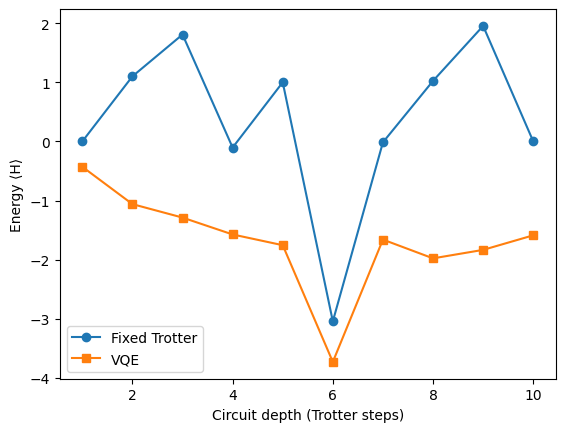

In [37]:
import matplotlib.pyplot as plt

trotter_vals = []
vqe_vals = []

for steps in depths:
    trotter_vals.append(fixed_trotter_energy(steps))
    vqe_vals.append(vqe_energy(steps))

plt.plot(depths, trotter_vals, "o-", label="Fixed Trotter")
plt.plot(depths, vqe_vals, "s-", label="VQE")
plt.xlabel("Circuit depth (Trotter steps)")
plt.ylabel("Energy ⟨H⟩")
plt.legend()
plt.show()

In [40]:
#It can also be seen here that VQE is generating population with lower energy than the trotter circuit given in paper!!